In [28]:
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
import torch
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import torch.nn as nn
import timm
import os
from typing import Tuple, Callable, Union
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [29]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(
        self, 
        root_dir: str, 
        info_df: pd.DataFrame, 
        transform: Callable,
        is_inference: bool = False
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.is_inference = is_inference
        self.image_paths = info_df['image_path'].tolist()
        
        if not self.is_inference:
            self.targets = info_df['target'].tolist()

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Union[Tuple[torch.Tensor, int], torch.Tensor]:
        img_path = os.path.join(self.root_dir, self.image_paths[index])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)

        if self.is_inference:
            return image
        else:
            target = self.targets[index]
            return image, target

In [30]:
# Albumentations Transform 클래스 정의
# 학습했던 agumentation 으로 설정 필요
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        common_transforms = [
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]
        
        if is_train:
            self.transform = A.Compose(
                [
                    A.OneOf([
                        A.RandomCrop(64, 64),  # 50% 확률로 랜덤 크롭 적용
                        A.Resize(224, 224)  # 나머지 50% 확률로 리사이즈 유지
                    ], p=0.5),
                    A.HorizontalFlip(p=0.5),  # 90% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=30),  # 최대 30도 회전
                    A.RandomBrightnessContrast(brightness_limit=(-0.2, -0.2), contrast_limit=0, p=1), # 20% 어둡게
                    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.7, 1.3), p=1),
                    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5), 
                ] + common_transforms
            )
        else:
            self.transform = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        transformed = self.transform(image=image)
        return transformed['image']

In [31]:
# TransformSelector 클래스 정의
class TransformSelector:
    def __init__(self, transform_type: str):
        if transform_type in ["torchvision", "albumentations"]:
            self.transform_type = transform_type
        else:
            raise ValueError("Unknown transformation library specified.")

    def get_transform(self, is_train: bool):
        if self.transform_type == 'albumentations':
            transform = AlbumentationsTransform(is_train=is_train)
        return transform

In [32]:
# 모델 선택 클래스 정의
class TimmModel(nn.Module):
    def __init__(
        self, 
        model_name: str, 
        num_classes: int, 
        pretrained: bool
    ):
        super(TimmModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# timm 모델 기반
class ModelSelector:
    def __init__(
        self, 
        model_type: str, 
        num_classes: int, 
        **kwargs
    ):
        if model_type == 'timm':
            self.model = TimmModel(num_classes=num_classes, **kwargs)
        else:
            raise ValueError("Unknown model type specified.")

    def get_model(self) -> nn.Module:
        return self.model


In [33]:
# 장비 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
# 데이터 경로 설정
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

# 데이터 로드
train_info = pd.read_csv(traindata_info_file)
test_info = pd.read_csv(testdata_info_file)

# 클래스 수 설정
num_classes = len(train_info['target'].unique())
print("class = ", num_classes)

# Transform 설정
transform_selector = TransformSelector(transform_type = "albumentations")
test_transform = transform_selector.get_transform(is_train=False)

# 테스트 데이터셋 및 데이터로더 정의
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64,
    shuffle=False
)

class =  500


In [35]:
# 모델 로드
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet101', 
    pretrained=True
)
model = model_selector.get_model()

# 학습된 모델 가중치 로드 (경로는 실제 모델 파일 경로로 수정)
model.load_state_dict(torch.load('./train_result/best_model.pt', map_location=device))
model.to(device)
model.eval()

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [36]:
# 메모리 정리
# grad-cam 사용 후 메모리 정리 코드
torch.cuda.empty_cache()
print("done")

done


In [37]:
# visualize_gradcam 함수 정의
def visualize_gradcam(
        model: torch.nn.Module,
        device: torch.device,
        dataloader: DataLoader,
        target_layer: str,
        num_images: int,
        random_indices: list = None,  # random_indices 이미지
        num_classes: int = 500 # class 수
    ):

    cam_extractor = GradCAM(model, target_layer)
    model.eval()

    # 랜덤으로 시각화할 num_images개 이미지 선택
    total_images = len(dataloader.dataset)
    if random_indices is None: # random_indices가 없을 때만 랜덤 선택
        random_indices = random.sample(range(total_images), num_images)
    else:
        random_indices = random_indices[:num_images]  # 입력된 random_indices가 num_images 개수만큼 잘림

    # 시각화를 위한 Figure 준비
    fig, axes = plt.subplots(num_images, 3, figsize=(18, 6 * num_images))

    current_index = 0
    selected_indices = set(random_indices)

    for inputs in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # 예측된 클래스 인덱스 가져오기

        batch_size = inputs.size(0)
        for j in range(batch_size):
            if current_index in selected_indices:
                # 예측된 클래스 인덱스가 num_classes 범위 내에 있는지 확인
                class_idx = preds[j].item()
                print("class_idx = ", class_idx)

                # Grad-CAM 추출
                cam = cam_extractor(class_idx=class_idx, scores=outputs)[0]
                cam = cam.mean(dim=0).cpu().numpy()

                # CAM을 원본 이미지 크기로 리사이즈
                cam = cv2.resize(cam, (inputs[j].shape[2], inputs[j].shape[1]))
                cam = (cam - cam.min()) / (cam.max() - cam.min())  # 정규화
                cam = np.uint8(255 * cam)

                # 컬러맵 적용 (열 지도 형태로 시각화)
                cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
                cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환

                # 입력 이미지를 처리
                input_image = inputs[j].cpu().numpy().transpose((1, 2, 0))
                input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
                input_image = (input_image * 255).astype(np.uint8)

                img_idx = list(selected_indices).index(current_index)
                ax_row = axes[img_idx] if num_images > 1 else axes

                # 원본 이미지 시각화
                ax_row[0].imshow(input_image)
                ax_row[0].set_title(f"Original Image {current_index}")
                ax_row[0].axis('off')

                # Grad-CAM 이미지 시각화 (모델이 주목한 영역을 강조)
                ax_row[1].imshow(cam)
                ax_row[1].set_title("Grad-CAM Image")
                ax_row[1].axis('off')

                # 원본 이미지와 Grad-CAM 이미지를 합성한 오버레이 이미지 생성
                overlay = cv2.addWeighted(input_image, 0.5, cam, 0.5, 0)
                ax_row[2].imshow(overlay)
                ax_row[2].set_title("Overlay Image")
                ax_row[2].axis('off')
            current_index += 1
            if current_index >= total_images:
                break

    plt.tight_layout()
    plt.show()

In [38]:
# random_indices
random_indices = random.sample(range(len(test_loader.dataset)), 3)  # 3개 이미지 선택

In [39]:
# layer 선택 (resnet101 기준)

# 전체 layers
# layers_to_visualize = [
#     'conv1',               # 초기 Convolution Layer
#     'layer1.0.conv1',       # Layer 1의 첫 번째 Block의 첫 번째 Conv Layer
#     'layer1.0.conv2',       # Layer 1의 첫 번째 Block의 두 번째 Conv Layer
#     'layer1.0.conv3',       # Layer 1의 첫 번째 Block의 세 번째 Conv Layer
#     'layer2.0.conv1',       # Layer 2의 첫 번째 Block의 첫 번째 Conv Layer
#     'layer2.3.conv2',       # Layer 2의 네 번째 Block의 두 번째 Conv Layer
#     'layer3.5.conv3',       # Layer 3의 여섯 번째 Block의 마지막 Conv Layer
#     'layer4.2.conv3',       # Layer 4의 마지막 Block의 마지막 Conv Layer
#     'layer4.2.act2',        # 마지막 레이어 활성화
#     'avgpool',              # Global Average Pooling Layer
#     'fc'                    # Fully Connected Layer
# ]

layers_to_visualize = [
    'layer1.0.conv1',  # 초기 레이어
    'layer2.1.conv2',  # 중간 레이어
    'layer3.2.conv3',  # 더 깊은 레이어
    'layer4.2.act2'    # 마지막 레이어
]

Visualizing Grad-CAM for layer: layer1.0.conv1
class_idx =  205
class_idx =  8
class_idx =  475


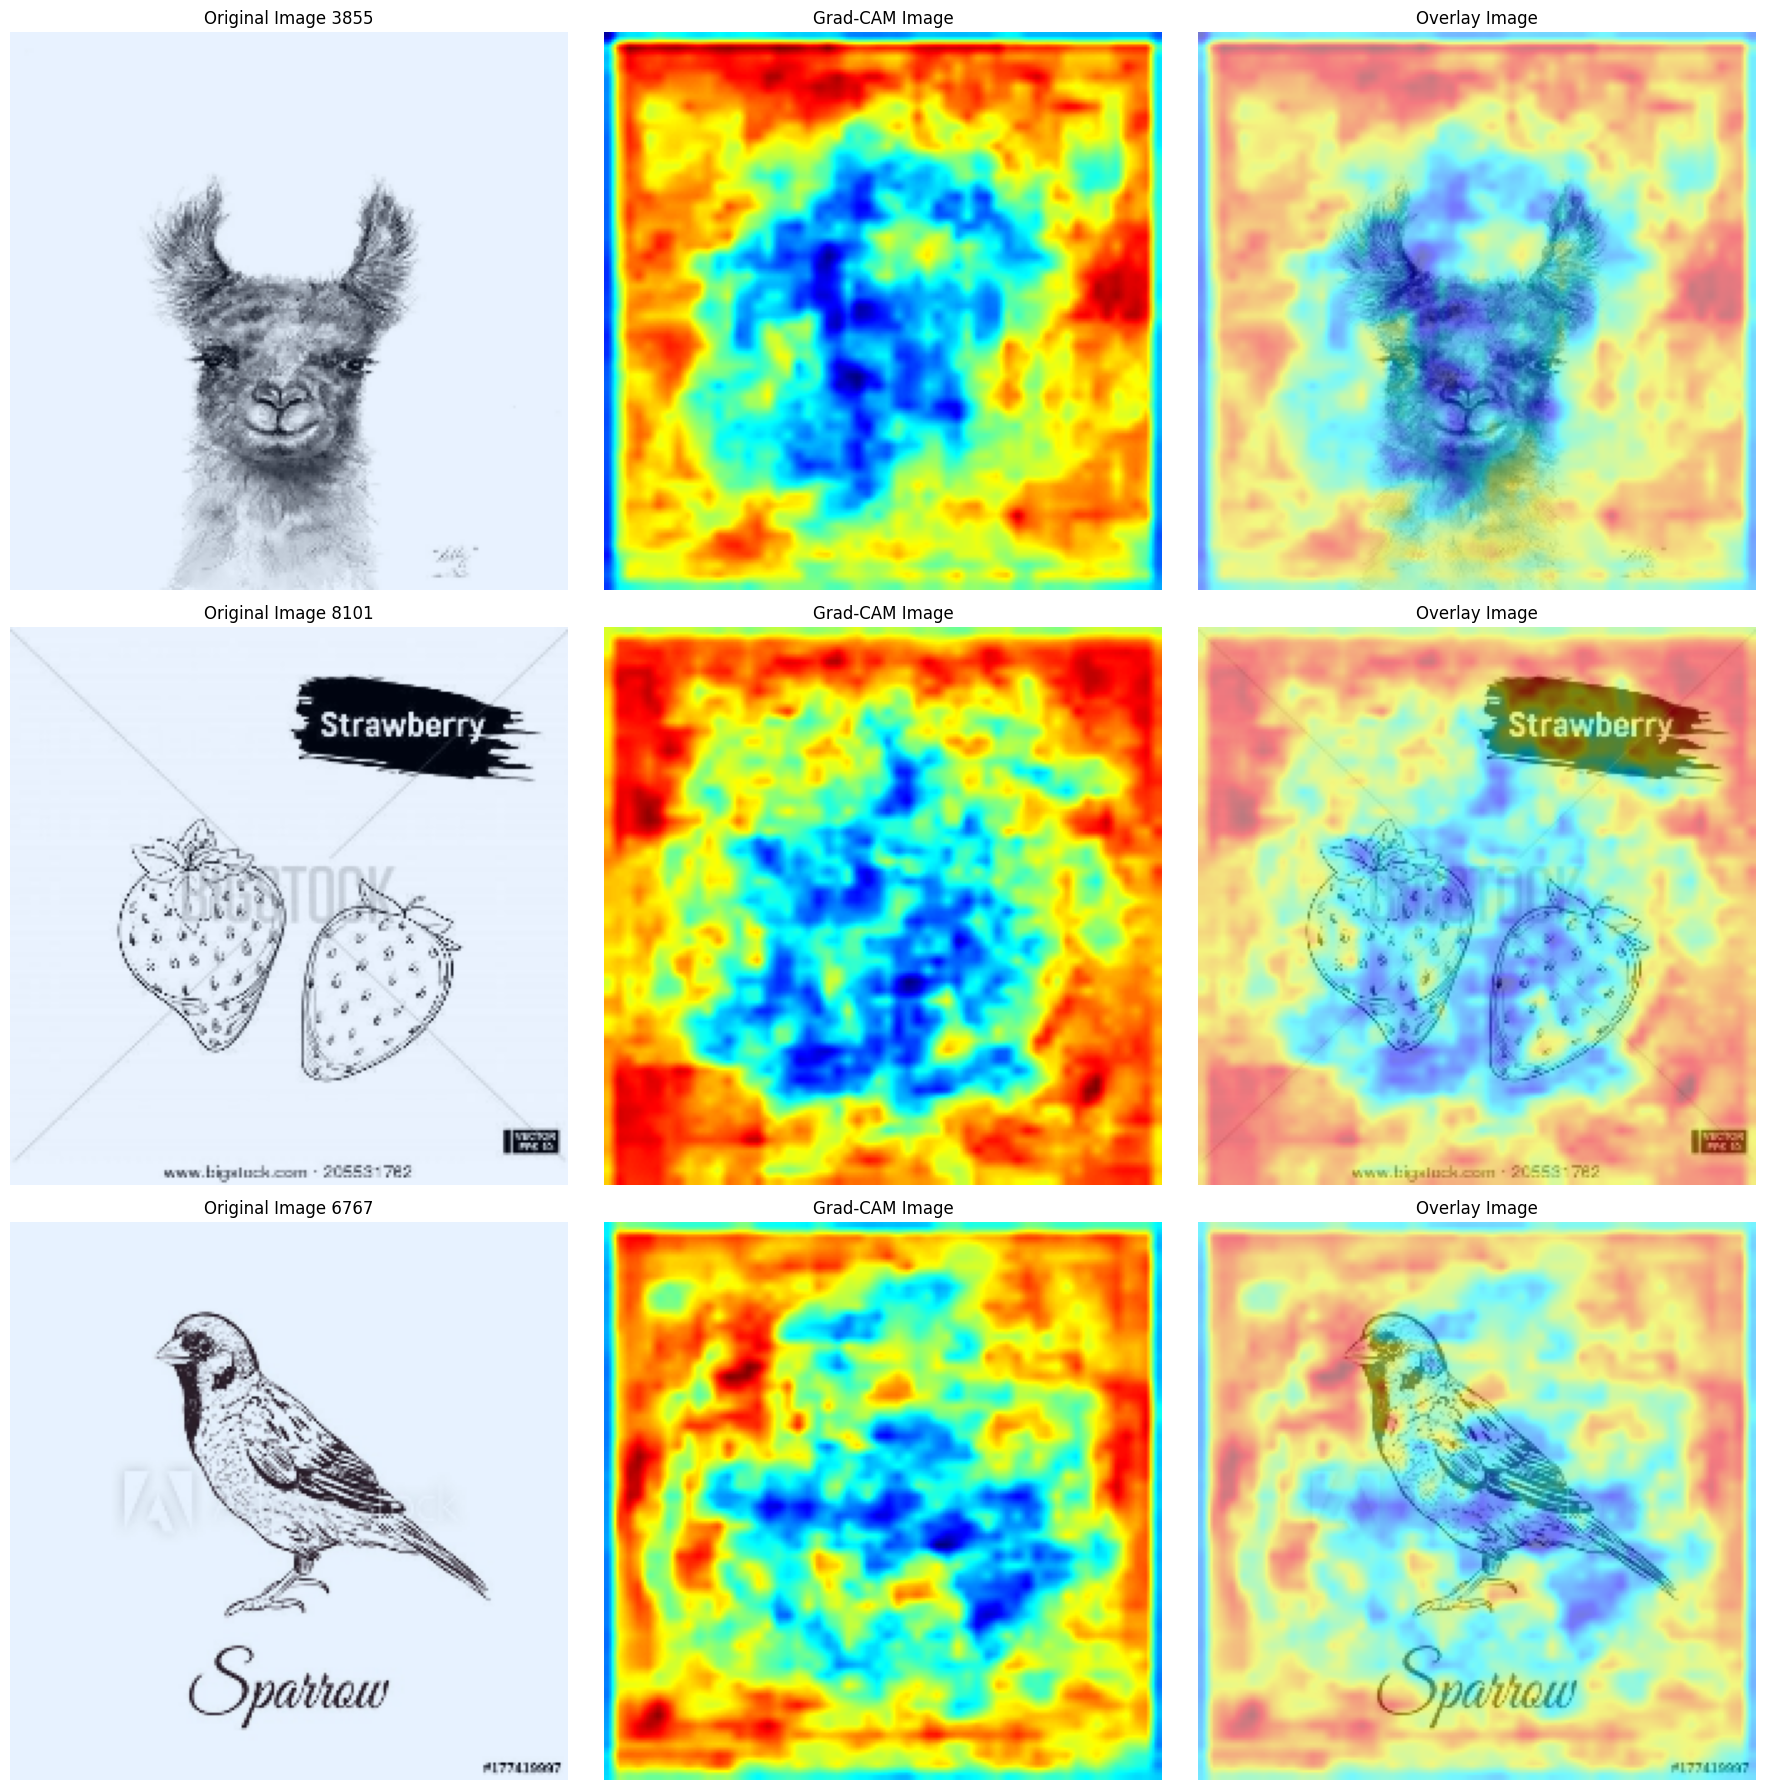

Visualizing Grad-CAM for layer: layer2.1.conv2
class_idx =  205
class_idx =  8
class_idx =  475


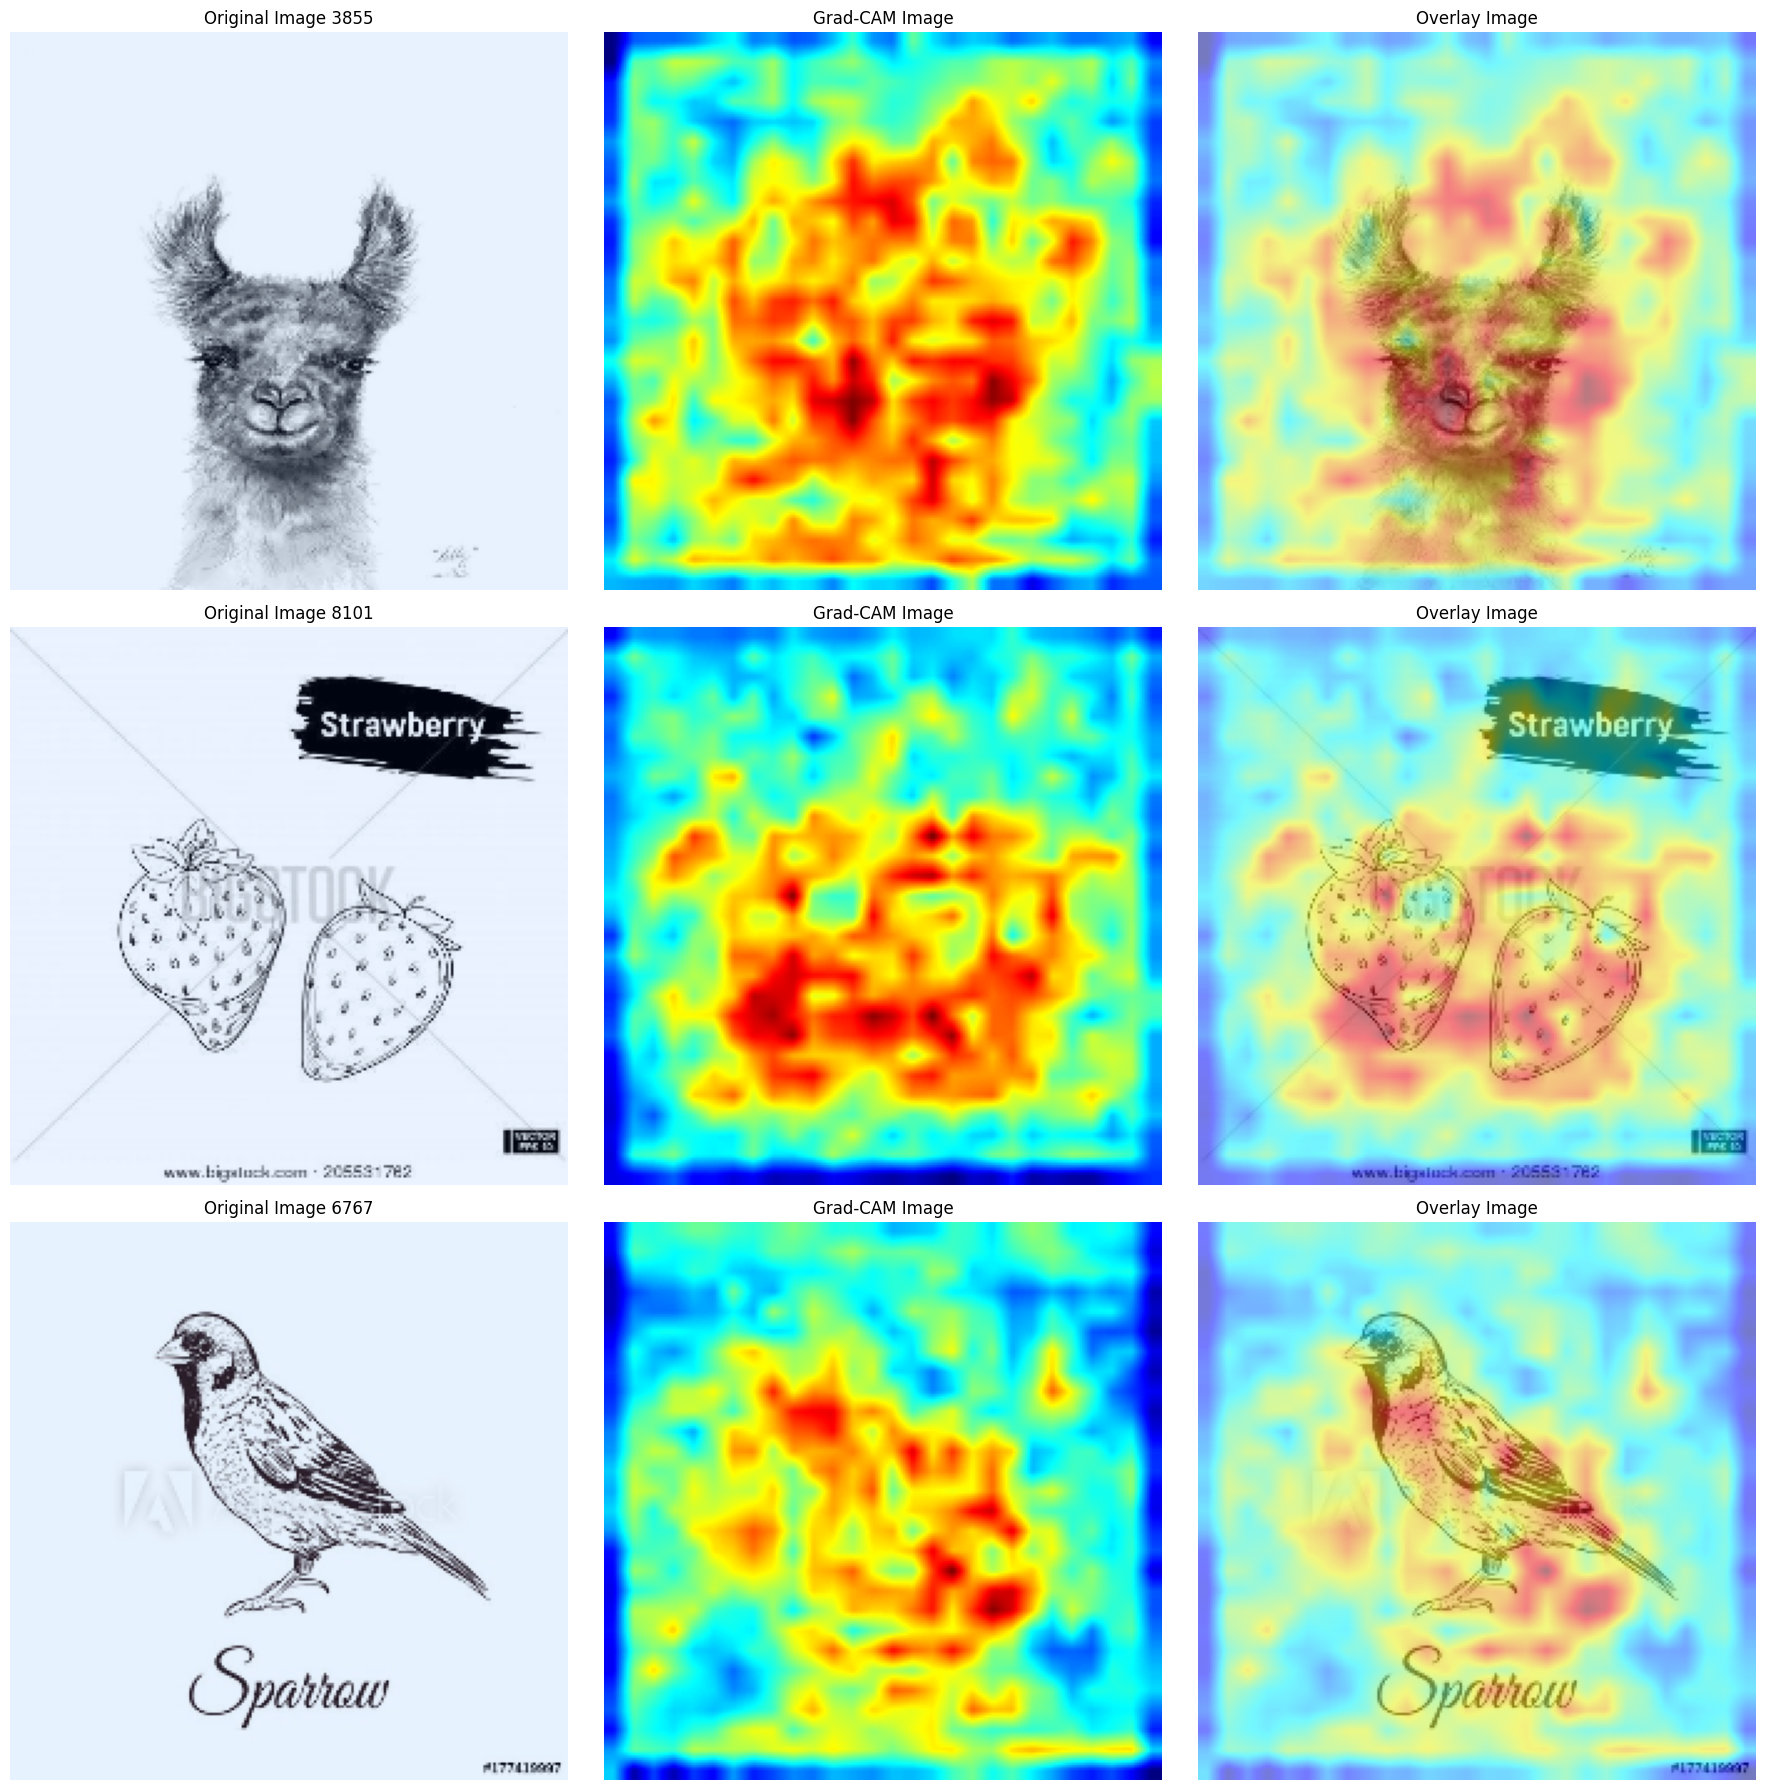

Visualizing Grad-CAM for layer: layer3.2.conv3
class_idx =  205
class_idx =  8
class_idx =  475


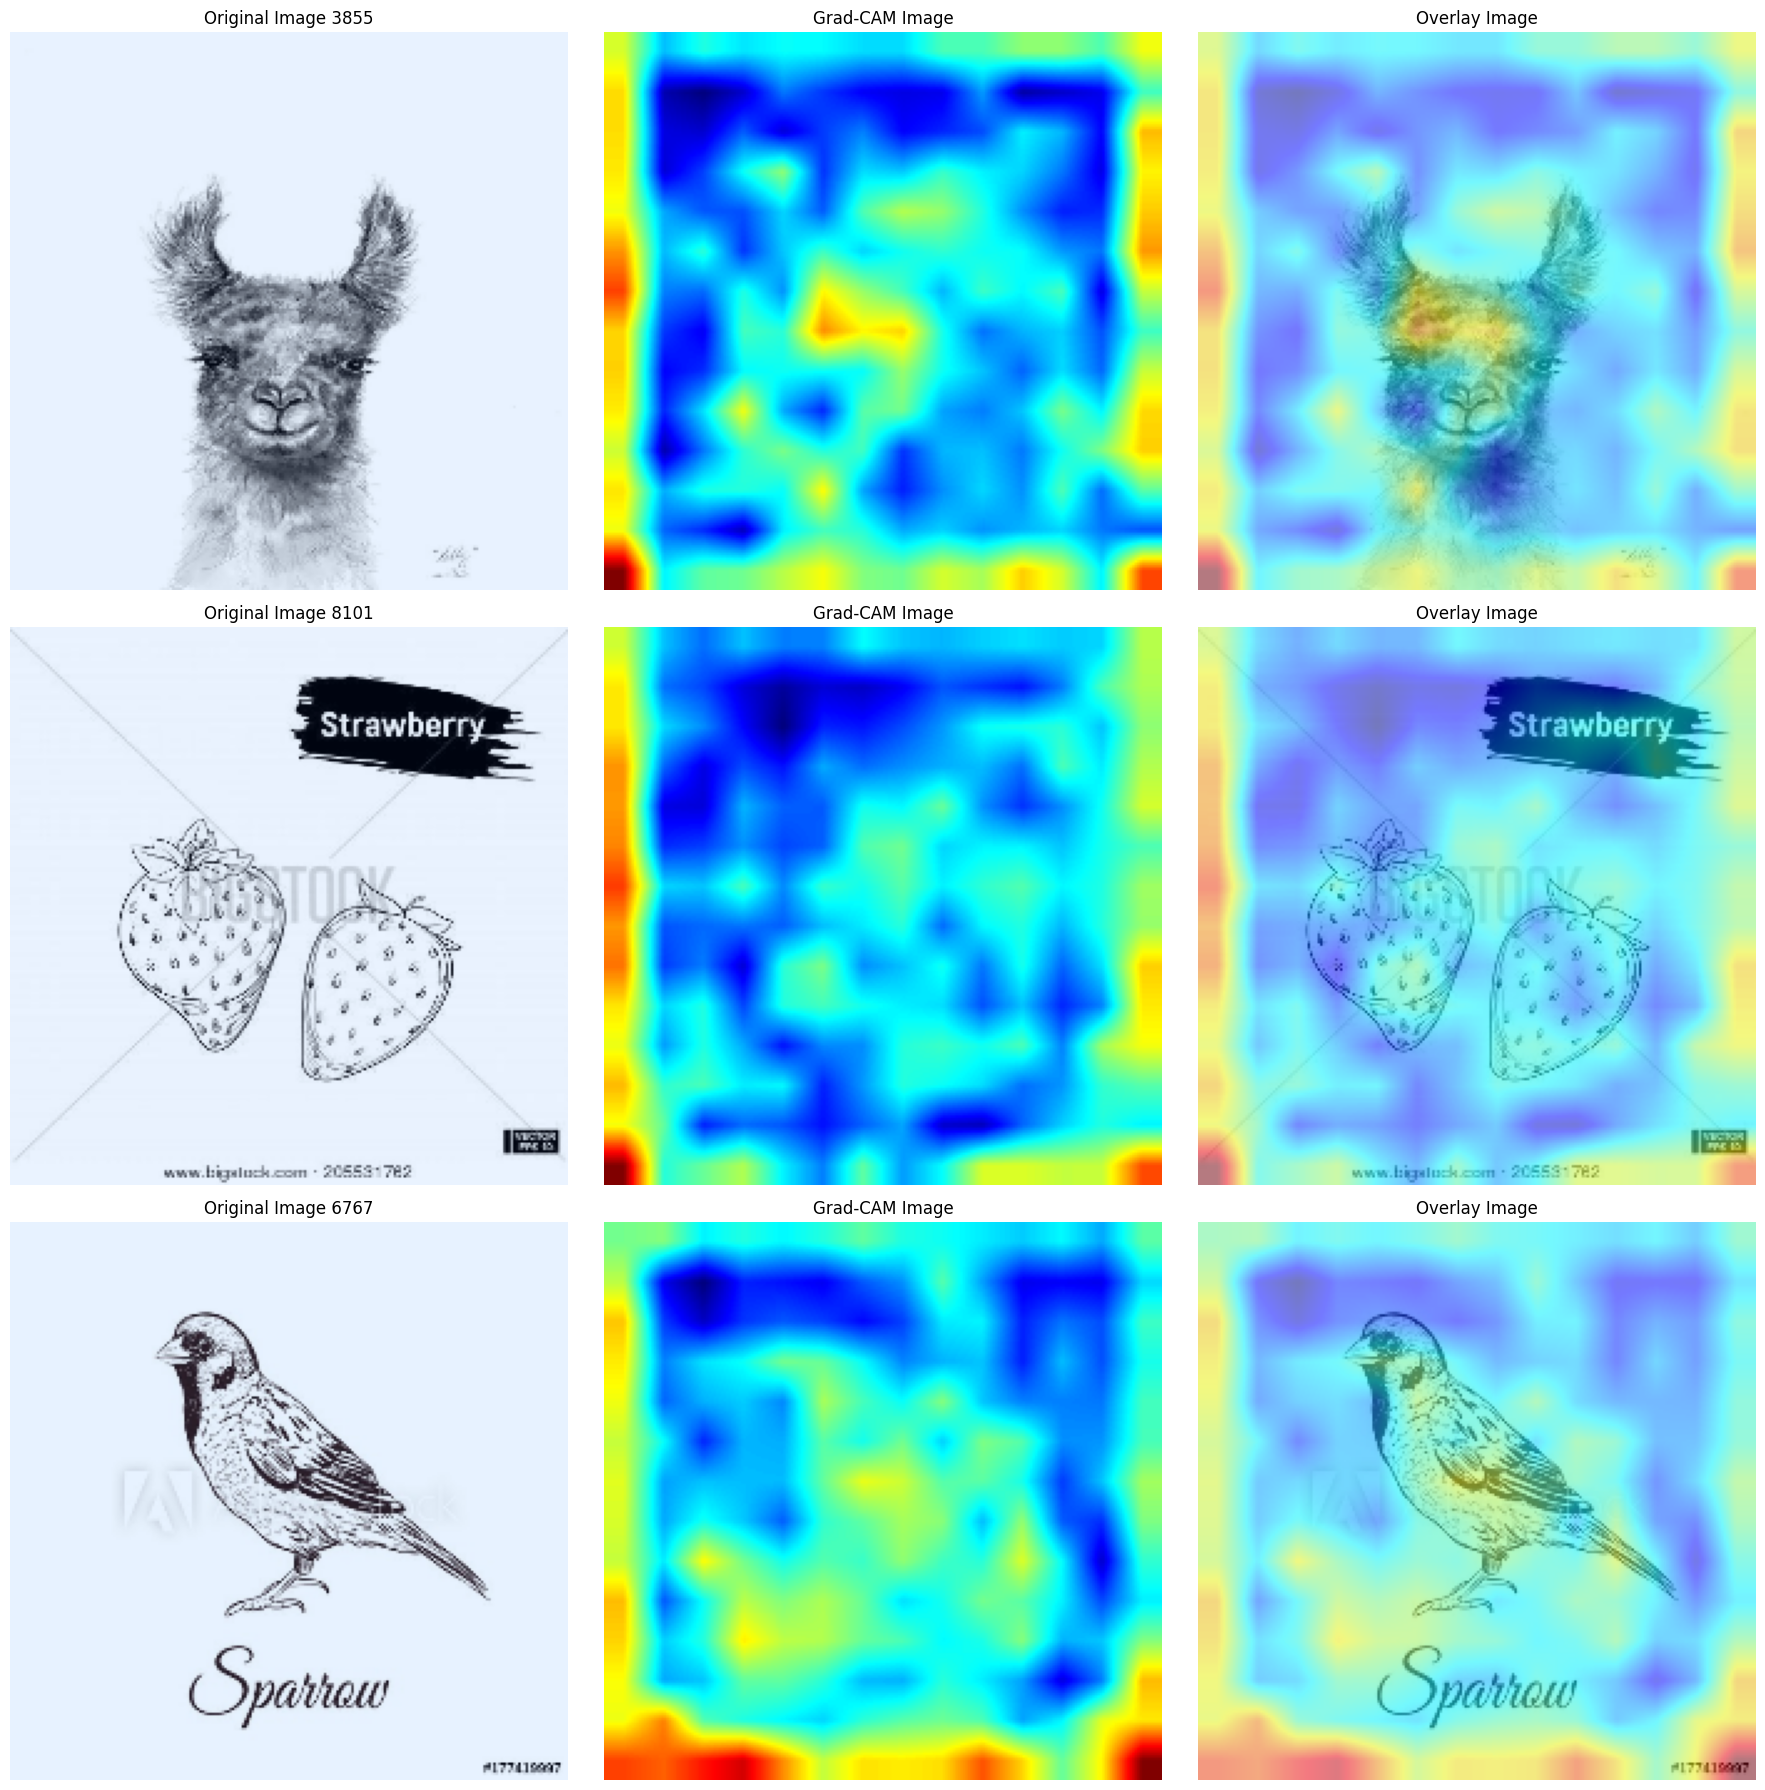

Visualizing Grad-CAM for layer: layer4.2.act2
class_idx =  205
class_idx =  8
class_idx =  475


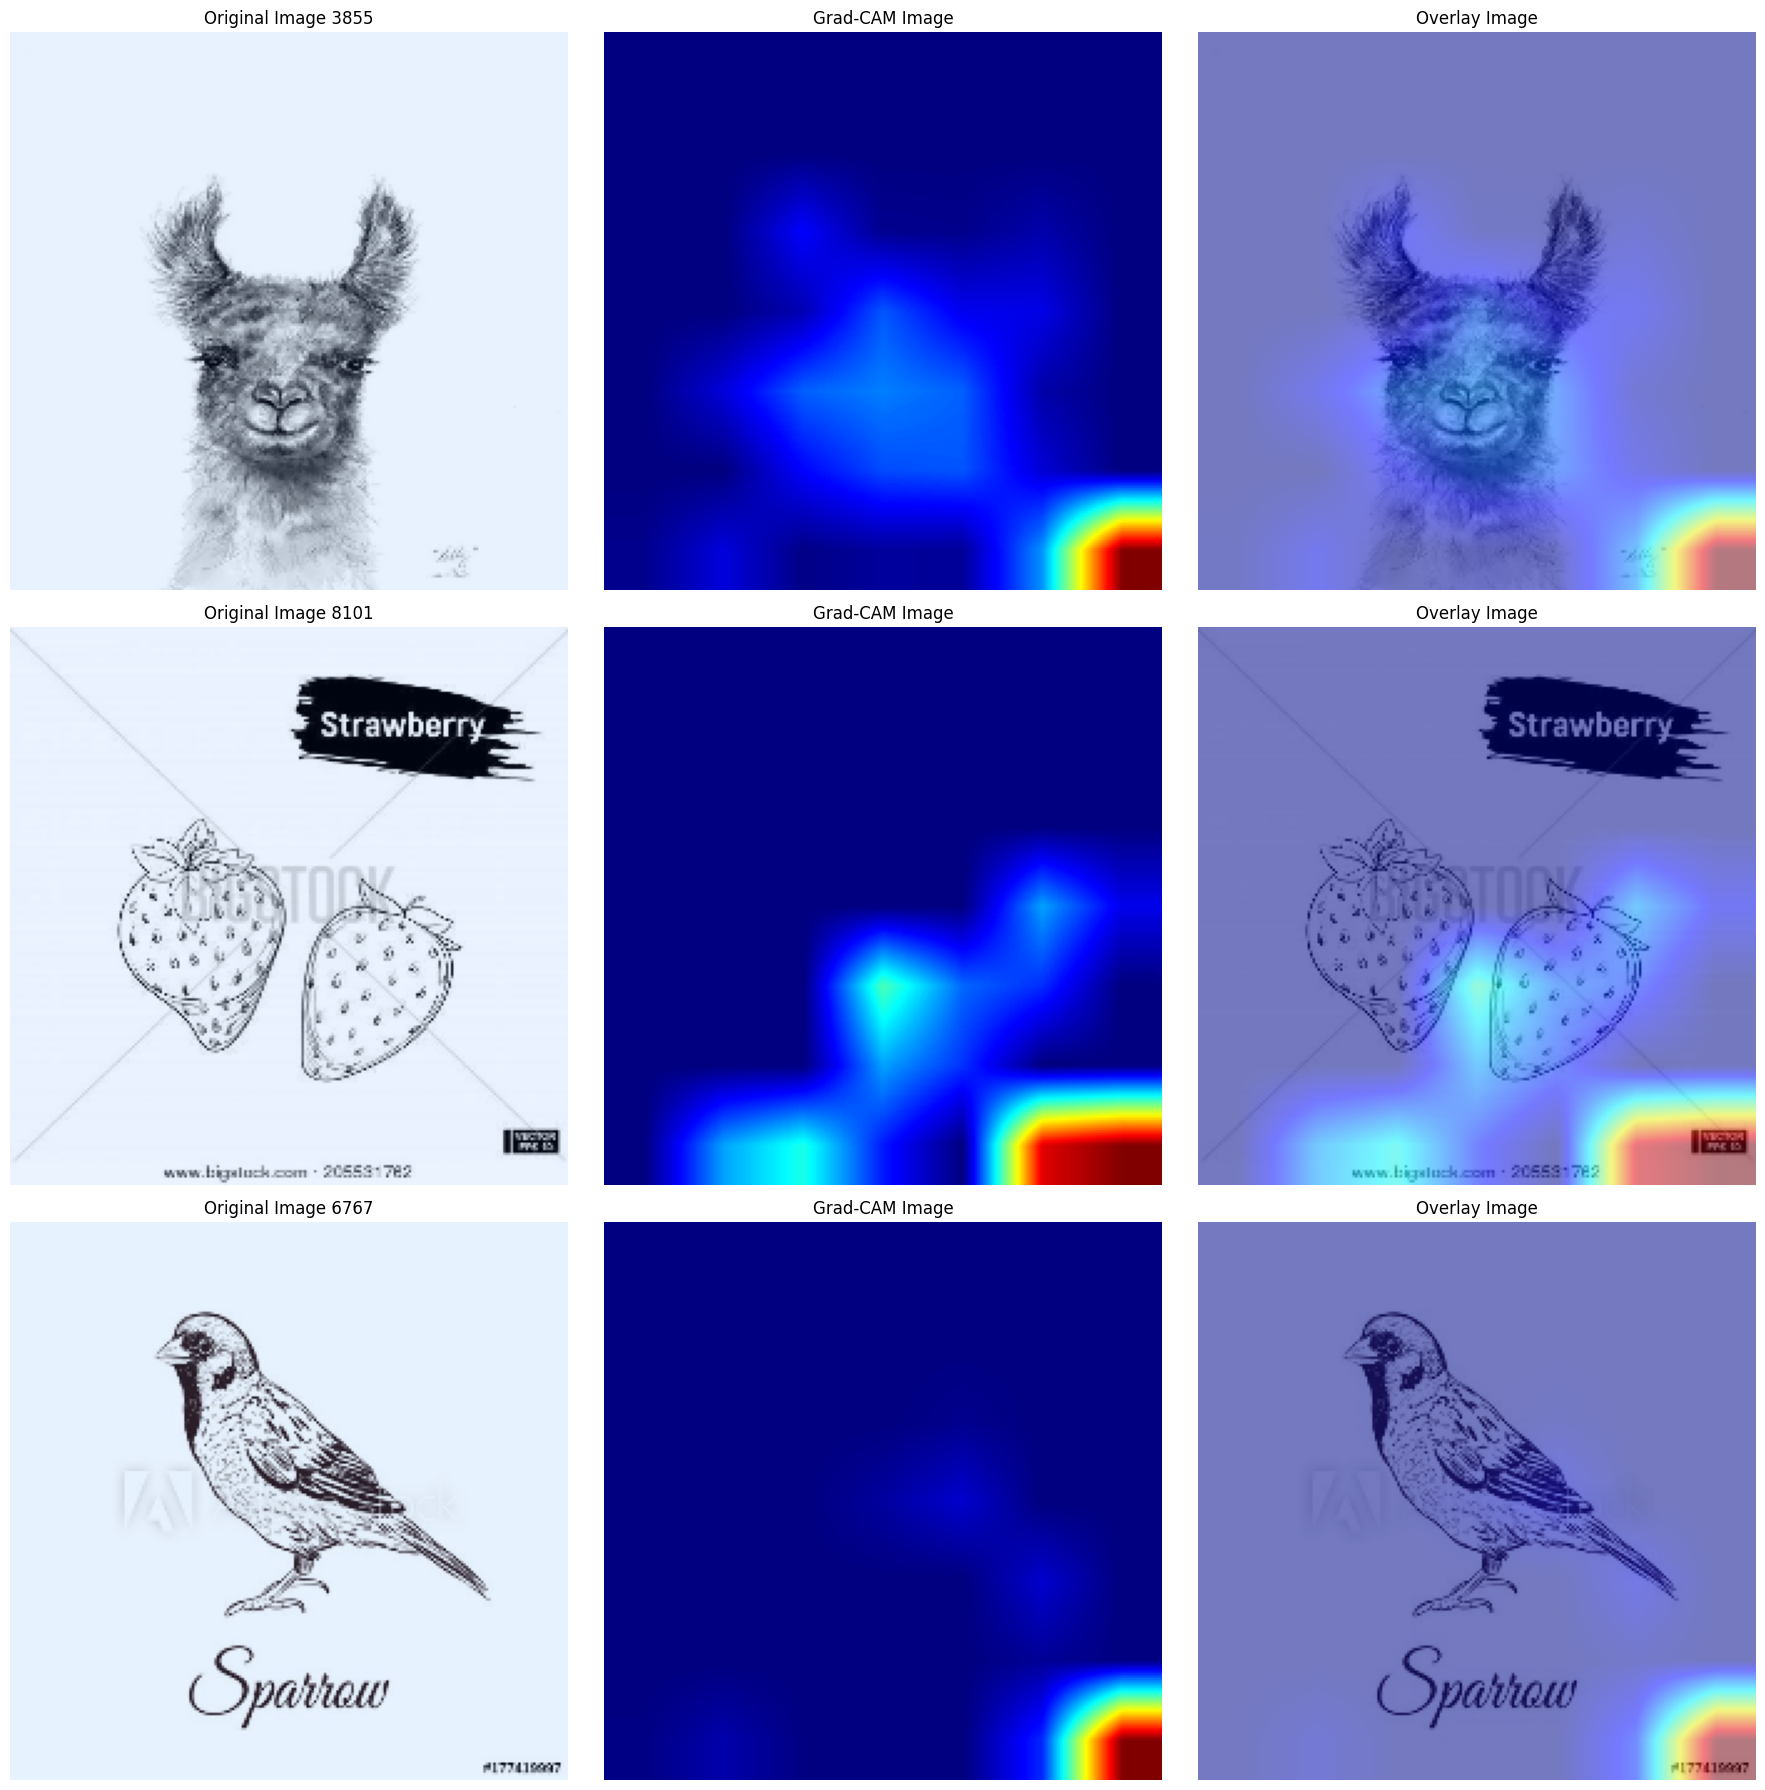

In [40]:
# Grad-CAM 시각화 실행
for layer in layers_to_visualize:
    print(f"Visualizing Grad-CAM for layer: {layer}")
    visualize_gradcam(model.model, device, test_loader, target_layer=layer, num_images=3, random_indices=random_indices)